This notebook is used to test different augmentation techniques on a single
example image taken from the training dataset.

In [2]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
from pathlib import Path
import pandas as pd
import numpy as np
from tensorflow.keras import layers, Input
import matplotlib.pyplot as plt
import random
import tensorflow.keras.backend as K

def initialise_session():
    K.clear_session()
    physical_devices = tf.config.list_physical_devices('GPU')
    num_physical_devices = len(physical_devices)
    print("GPUs Available: ", num_physical_devices)
    if num_physical_devices > 0:
        tf.config.set_visible_devices(physical_devices[0], 'GPU')
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        
def find_directory():
    try:
        # Check if running in a Jupyter notebook
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            # Running in a Jupyter notebook
            directory = os.getcwd()
        else:
            # Running in a standalone Python script
            directory = Path(__file__).parent
    except NameError:
        # Running in a standalone Python script
        directory = Path(__file__).parent
    return directory

def build_train_image_paths(path_to_data):
    training_norm_path = f"{path_to_data}/training_norm.csv"
    training_norm = pd.read_csv(training_norm_path)
    training_norm["speed"] = training_norm["speed"].astype(int)
    training_norm["image_id"] = training_norm["image_id"].apply(lambda x: f"{path_to_data}/training_data/combined/{x}.png")
    training_norm.rename(columns={"image_id": "image_path"}, inplace=True)
    
    train_image_paths_0 = training_norm[training_norm['speed'] == 0].reset_index(drop=True)
    train_image_paths_1 = training_norm[training_norm['speed'] == 1].reset_index(drop=True)
    return train_image_paths_0, train_image_paths_1

def load_training_images_and_labels(image_path, labels, weights, image_shape):
    # Define a function that maps each row to an image and a pair of labels
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, image_shape)
    speed_label = labels[0]
    angle_label = labels[1]
    speed_label = tf.cast(speed_label, tf.int32)
    angle_label = tf.cast(angle_label, tf.float32)
    return image, (speed_label, angle_label), weights

def prepare_image(image_shape):
    initialise_session()
    directory = find_directory()
    path_to_data = f"{directory}/machine-learning-in-science-ii-2023"
    train_image_paths_0, train_image_paths_1 = build_train_image_paths(path_to_data)
    dataset_0 = tf.data.Dataset.from_tensor_slices((train_image_paths_0['image_path'], 
                                                    (train_image_paths_0['speed'], train_image_paths_0['angle']),
                                                    (None, None)
                                                    ))
    dataset_0 = dataset_0.map(lambda x,y,z: load_training_images_and_labels(x,y,z, image_shape))
    original_image, label, weights = next(iter(dataset_0))
    original_image = np.uint8(original_image)
    return original_image

def visualize(original, augmented):
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(original)
    plt.subplot(1,2,2)
    plt.title('Augmented image')
    plt.imshow(augmented)

#### Original Image

GPUs Available:  0


Text(0.5, 1.0, 'Target speed: 0\nTarget angle: 0.4375')

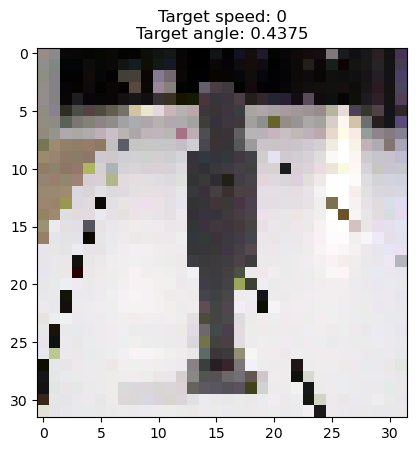

In [13]:
original_image = prepare_image((32, 32))
plt.imshow(original_image)
plt.title(f"Target speed: {label[0].numpy()}\nTarget angle: {label[1].numpy()}")

#### Random flip + rotation

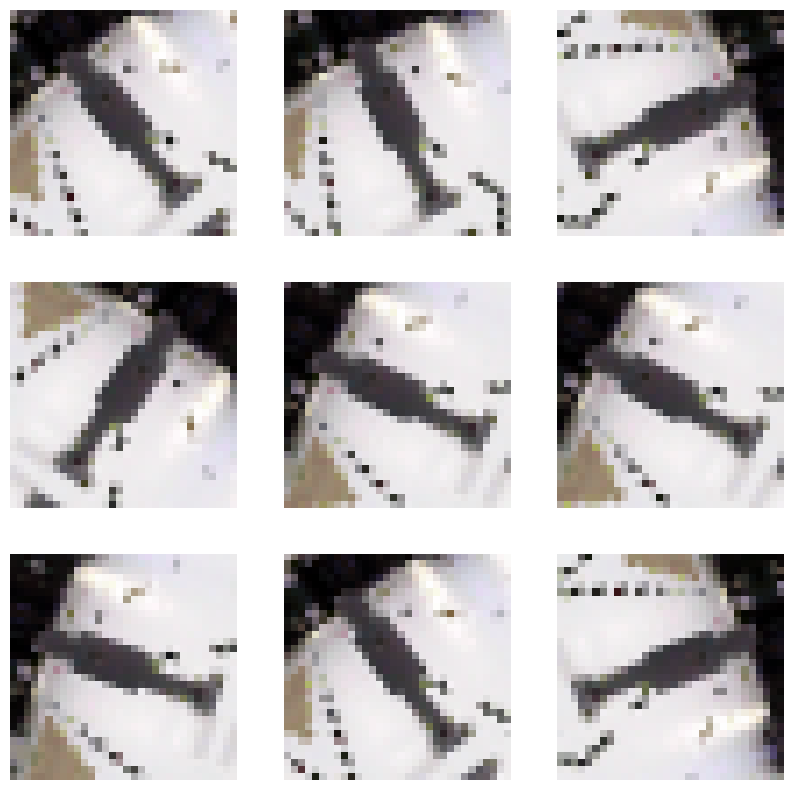

In [5]:
data_augmentation = tf.keras.Sequential([
    # layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])
batched_original_image = tf.cast(tf.expand_dims(original_image, 0), tf.float32)
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = np.uint8(data_augmentation(batched_original_image))
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0])
    plt.axis("off")

#### Random brightness

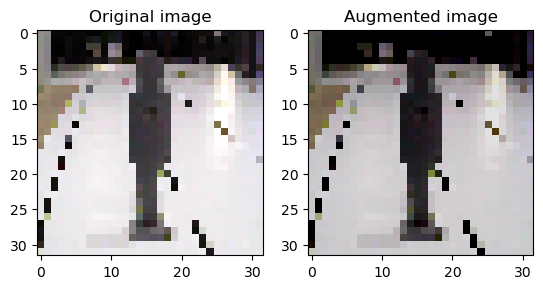

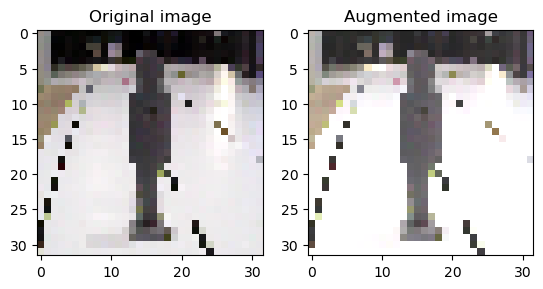

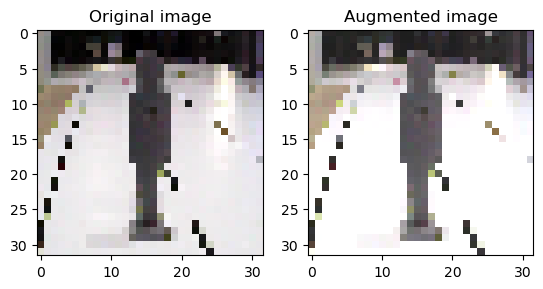

In [6]:
seed = random.randrange(100),(random.randrange(100))
for i in range(3):
    seed = (i, 0)
    stateless_random_brightness = tf.image.stateless_random_brightness(
        original_image, max_delta=0.2, seed=seed)
    visualize(original_image, stateless_random_brightness)

#### Random contrast - tf.image

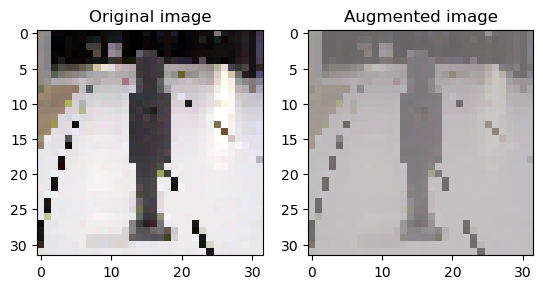

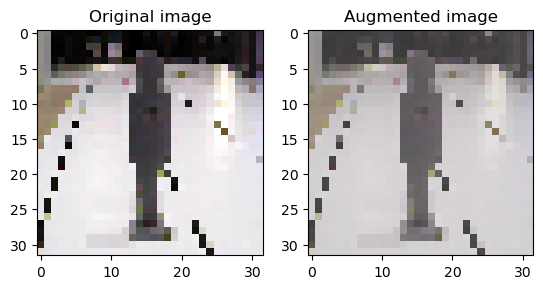

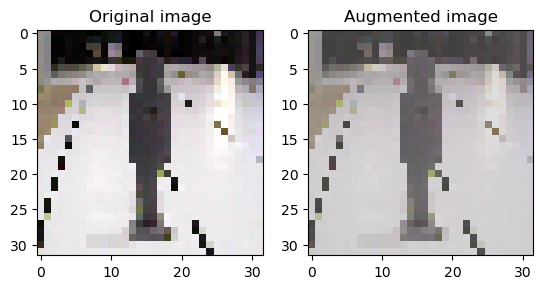

In [8]:
seed = random.randrange(100),(random.randrange(100))
for i in range(3):
  seed = (i, 0)
  stateless_random_contrast = tf.image.stateless_random_contrast(
      original_image, lower=0.3, upper=0.7, seed=seed)
  visualize(original_image, stateless_random_contrast)

#### Random contrast - keras

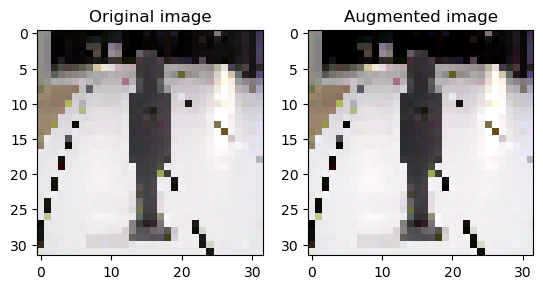

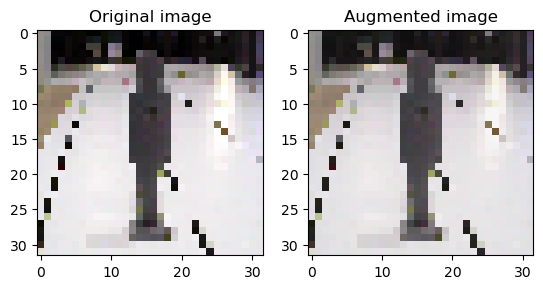

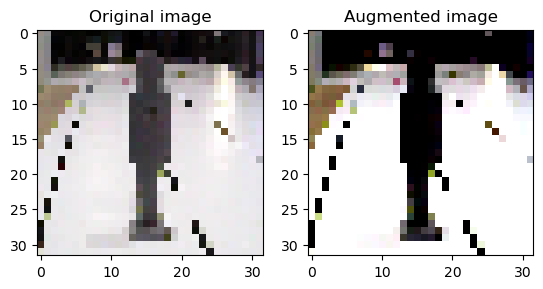

In [9]:
seed = random.randrange(100),(random.randrange(100))
data_augmentation = tf.keras.Sequential([
    layers.RandomContrast(factor=(0.3, 0.7))
])
for i in range(3):
    augmented_image = np.uint8(data_augmentation(original_image))
    visualize(original_image, augmented_image)

#### Random crop

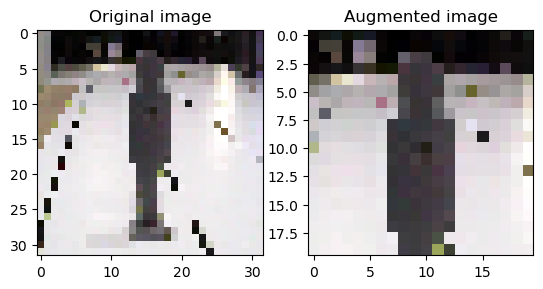

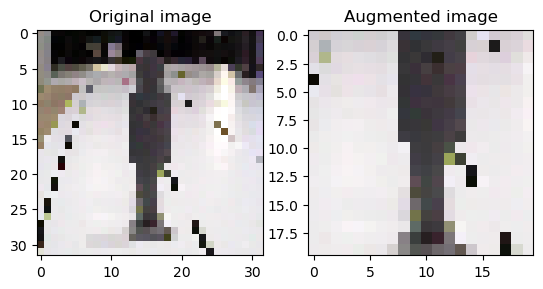

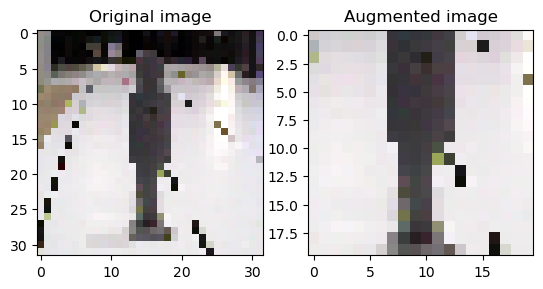

In [10]:
for i in range(3):
  seed = (i, 0)
  stateless_random_crop = tf.image.stateless_random_crop(
      original_image, size=[20, 20, 3], seed=seed)
  visualize(original_image, stateless_random_crop)

#### Random saturation

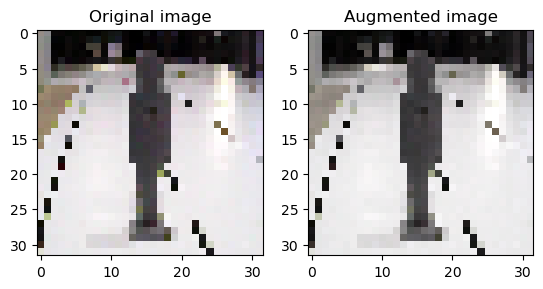

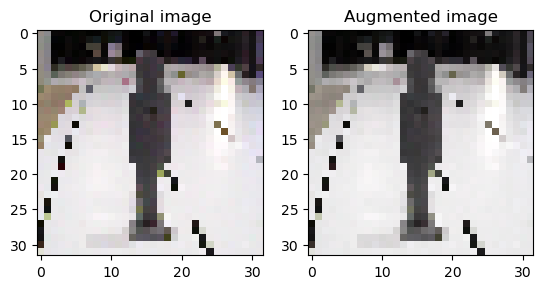

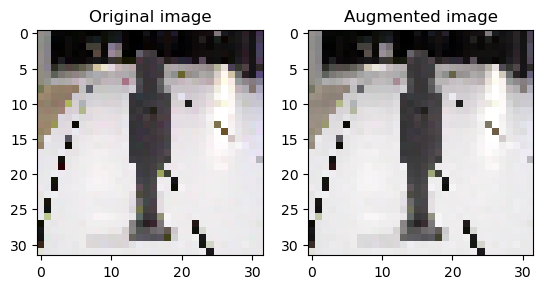

In [11]:
for i in range(3):
  seed = random.randrange(100),(random.randrange(100))
  stateless_random_contrast = tf.image.stateless_random_saturation(
      original_image, lower=0.3, upper=0.7, seed=seed)
  visualize(original_image, stateless_random_contrast)